# Лабораторная работа №6
# Деревья решений

### Деревья (принятия) решений

Дерево принятия решений представляет собой иерархическую древовидную структуру, состоящую из решающих правил вида «Если ..., то ...». Правила автоматически генерируются в процессе обучения на обучающем множестве.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Используем набор "Ирисы" (3 и 4 признаки):

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target

Визуализируем набор на плоскости:

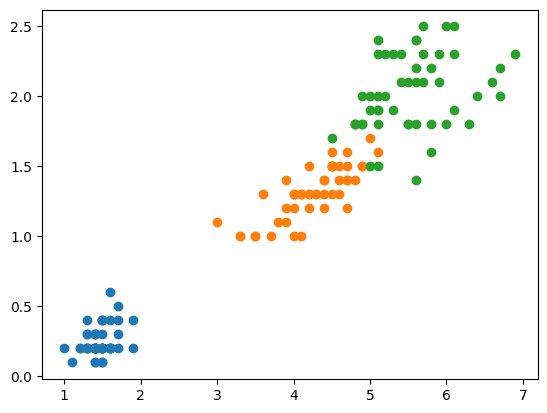

In [4]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

Для построения дерева решений будем использовать класс `DecisionTreeClassifier`:

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X, y);

Построим границу принятия решения:

In [6]:
def plot_decision_boundary(model, axis):

    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])

    plt.contourf(x0, x1, zz, cmap=custom_cmap)

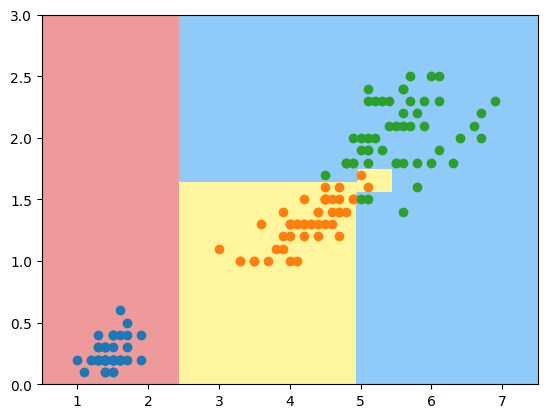

In [7]:
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

Визуализируем дерево принятия решений:

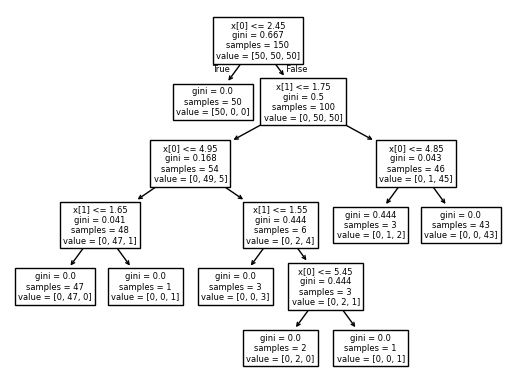

In [8]:
from sklearn.tree import plot_tree

plot_tree(dt_clf);

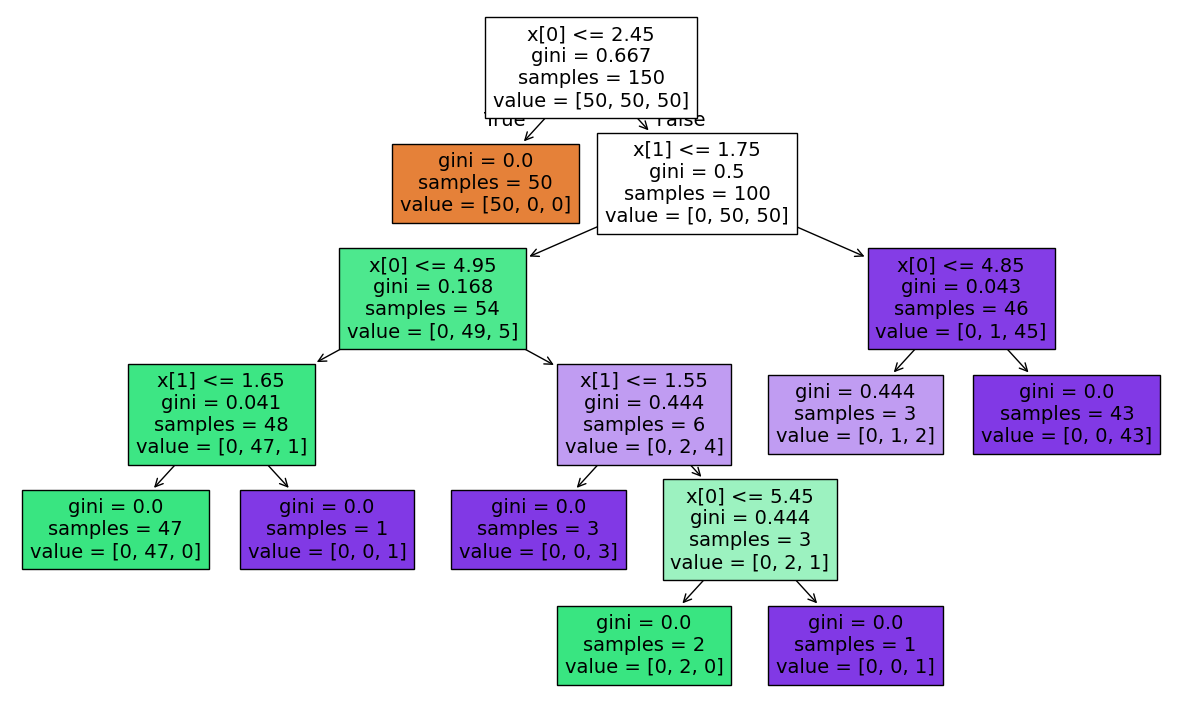

In [9]:
plt.figure(figsize=(15, 9))
plot_tree(dt_clf,filled=True);

### Энтропия

Энтропия измеряет размеры беспорядка или неопределенности в системе.

In [10]:
def entropy(p):
    return (-p * np.log(p) - (1-p) * np.log(1-p))/np.log(2.)

In [11]:
x = np.linspace(0.01, 0.99, 200)

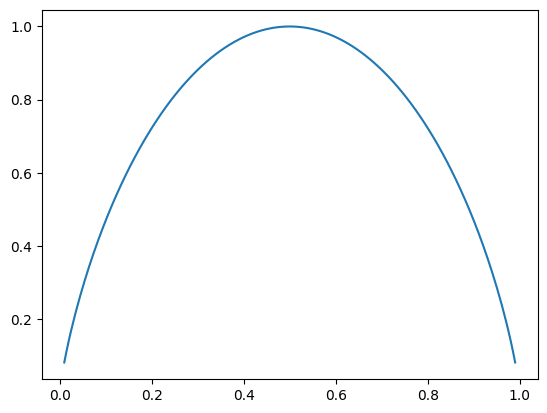

In [12]:
plt.plot(x, entropy(x))
plt.show()

### Оценка разбиения при помощи энтропии

Разбиение имеет более низкую энтропию (или низкий беспорядок), если оно относительно чисто, т.е. большинство точек имеют одну и ту же метку. С другой стороны, разбиение имеет более высокую энтропию (или беспорядок), если метки классов перемешаны и не существует определенного класса для большинства меток.

Если область чиста, т.е. состоит из точек одного и того же класса, то энтропия равна нулю.

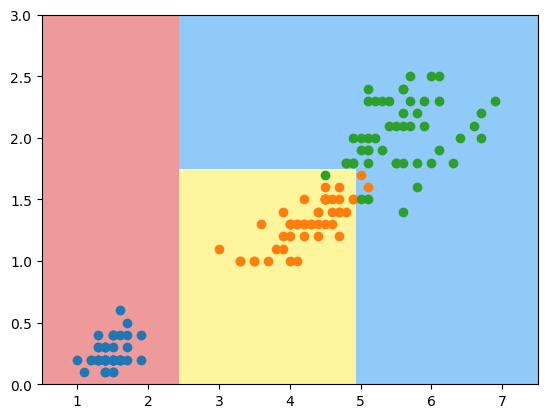

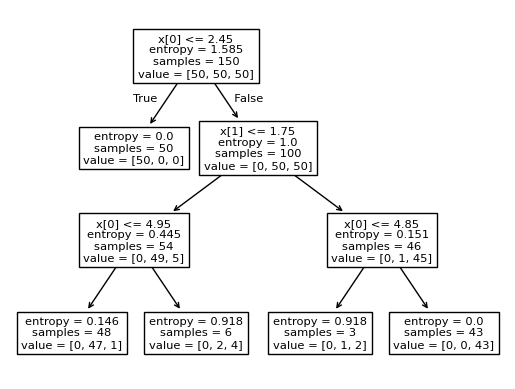

In [13]:
dt_clf = DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=42)
dt_clf.fit(X, y)
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()
plot_tree(dt_clf);

Решение (точка разбиения) $X_{d}\leqslant v$ разбивает пространство данных $\mathbf{D}$ на две области $\mathbf{D}_{Y}$ и $\mathbf{D}_{N}$, которые представляют собой множества всех возможных точек, которые удовлетворяют решению, и тех точек, которые ему не удовлетворяют.

In [14]:
def split(X, y, d, v):
    index_a = (X[:,d] <= v)
    index_b = (X[:,d] > v)
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [15]:
Dy,Dn,_,_ = split(X, y, 0, 1.4)
Dn[:10]

array([[1.5, 0.2],
       [1.7, 0.4],
       [1.5, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2]])

Энтропия множества помеченных точек $\mathbf{D}$ определяется как

$H\left(\mathbf{D}\right)=-\sum_{i=1}^{k}\mathbb{P}\left[c_{i}\mid\mathbf{D}\right]\,\log_{2}\mathbb{P}\left[c_{i}\mid\mathbf{D}\right],$

где $\mathbb{P}\left[c_{i}\mid\mathbf{D}\right]$ – вероятность класса $c_{i}$ в $\mathbf{D}$ и $k$ – число классов.


Если классы перемешаны и каждый появляется с равной вероятностью $\mathbb{P}\left[c_{i}\mid\mathbf{D}\right]=\frac{1}{k}$, то энтропия имеет наивысшее значение $H\left(\mathbf{D}\right)=\log_{2}k$.

In [16]:
from collections import Counter
from math import log

def entropy(y):
    counter = Counter(y)
    res = 0.0
    for num in counter.values():
        p = num / len(y)
        res += -p * log(p)
    return res/log(2.)

In [17]:
entropy(y)

1.584962500721156

In [18]:
log(3.)/log(2.)

1.5849625007211563

Определим энтропию разбиения (split entropy) как взвешенную энтропию каждой из образующихся областей

$H\left(\mathbf{D}_{Y},\mathbf{D}_{N}\right)=\frac{n_{Y}}{n}H\left(\mathbf{D}_{Y}\right)+\frac{n_{N}}{n}H\left(\mathbf{D}_{N}\right),$

где $n=\left|\mathbf{D}\right|$ – это число точек в $\mathbf{D}$ и $n_{Y}=\left|\mathbf{D}_{Y}\right|$ и $n_{N}=\left|\mathbf{D}_{N}\right|$ – это число точек в $\mathbf{D}_{Y}$ и $\mathbf{D}_{N}$.

Для определения параметров оптимального разбиения (включая энтропию) используем следующую функцию:

In [19]:
def try_split_ent(X, y):

    best_entropy = float('inf')
    best_d, best_v = -1, -1
    for d in range(X.shape[1]):
        sorted_index = np.argsort(X[:,d])
        for i in range(1, len(X)):
            if X[sorted_index[i], d] != X[sorted_index[i-1], d]:
                v = (X[sorted_index[i], d] + X[sorted_index[i-1], d])/2
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                p_l, p_r = len(X_l) / len(X), len(X_r) / len(X)
                e = p_l * entropy(y_l) + p_r * entropy(y_r)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v

    return best_entropy, best_d, best_v

In [20]:
best_entropy, best_d, best_v = try_split_ent(X, y)
print("Лучшая энтропия разбиения =", best_entropy)
print("Лучший признак (d) =", best_d)
print("Лучшая точка (v) =", best_v)

Лучшая энтропия разбиения = 0.6666666666666666
Лучший признак (d) = 0
Лучшая точка (v) = 2.45


In [21]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [22]:
entropy(y1_l)

0.0

In [23]:
entropy(y1_r)

1.0

In [24]:
best_entropy2, best_d2, best_v2 = try_split_ent(X1_r, y1_r)
print("Лучшая энтропия разбиения =", best_entropy2)
print("Лучший признак (d) =", best_d2)
print("Лучшая точка (v) =", best_v2)

Лучшая энтропия разбиения = 0.30983962924532515
Лучший признак (d) = 1
Лучшая точка (v) = 1.75


In [25]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [26]:
entropy(y2_l)

0.4450648570508386

In [27]:
entropy(y2_r)

0.15109697051711368

### Индекс Джини (Gini)

Индекс Джини (для множества) определяется следующим образом:

$G\left(\mathbf{D}\right)=1-\sum_{i=1}^{k}\mathbb{P}\left[c_{i}\mid\mathbf{D}\right]^{2}$

Если разбиение чисто, то индекс Джини равен нулю.

Взвешенный индекс Джини разбиения равен

$G\left(\mathbf{D}_{Y},\mathbf{D}_{N}\right)=\frac{n_{Y}}{n}G\left(\mathbf{D}_{Y}\right)+\frac{n_{N}}{n}G\left(\mathbf{D}_{N}\right)$

Чем меньше значение взвешенного индекса Джини, тем лучше разбиение.

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=42)
dt_clf.fit(X, y)
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()
plot_tree(dt_clf);

In [29]:
def gini(y):
    counter = Counter(y)
    res = 1.0
    for num in counter.values():
        p = num / len(y)
        res -= p**2
    return res

In [30]:
gini(y)

0.6666666666666665

In [31]:
def try_split_gini(X, y):

    best_g = float('inf')
    best_d, best_v = -1, -1
    for d in range(X.shape[1]):
        sorted_index = np.argsort(X[:,d])
        for i in range(1, len(X)):
            if X[sorted_index[i], d] != X[sorted_index[i-1], d]:
                v = (X[sorted_index[i], d] + X[sorted_index[i-1], d])/2
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                p_l, p_r = len(X_l) / len(X), len(X_r) / len(X)
                g = p_l * gini(y_l) + p_r * gini(y_r)
                if g < best_g:
                    best_g, best_d, best_v = g, d, v

    return best_g, best_d, best_v

In [32]:
best_g, best_d, best_v = try_split_gini(X, y)
print("Лучший взвешенный индекс Джини =", best_g)
print("Лучший признак (d) =", best_d)
print("Лучшая точка (v) =", best_v)

Лучший взвешенный индекс Джини = 0.3333333333333333
Лучший признак (d) = 0
Лучшая точка (v) = 2.45


In [33]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [34]:
gini(y1_l)

0.0

In [35]:
gini(y1_r)

0.5

In [36]:
best_g2, best_d2, best_v2 = try_split_gini(X1_r, y1_r)
print("Лучший взвешенный индекс Джини =", best_g2)
print("Лучший признак (d) =", best_d2)
print("Лучшая точка (v) =", best_v2)

Лучший взвешенный индекс Джини = 0.1103059581320451
Лучший признак (d) = 1
Лучшая точка (v) = 1.75


In [37]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [38]:
gini(y2_l)

0.1680384087791495

In [39]:
gini(y2_r)

0.04253308128544431

### Параметры конструктора класса DecisionTreeClassifier

Конструктор класса `DecisionTreeClassifier` имеет целый ряд параметров, включая следующие:

* criterion{“gini”, “entropy”}, default=”gini”
  * функция для измерения качества разбиения

* splitter{“best”, “random”}, default=”best”
  * стратегия разбиения

* max_depth: int, default=None
  * максимальная глубина дерева. Если None, то узлы раскрываются до тех пор, пока все листья не будут чистыми или пока все листья не будут содержать меньше, чем min_samples_split точек

* min_samples_split: int or float, default=2
  * минимальное количество точек для разбиения внутреннего узла

* min_samples_leaf: int or float, default=1
  * минимальное количество точек, необходимое на узле для разбиения

* max_leaf_nodes: int, default=None
  * максимальное количество узлов-листьев
  
Эти и другие параметры существенно влияют на работу классификатора.

In [40]:
from sklearn import datasets

X, y = datasets.make_moons(noise=0.2, random_state=666)

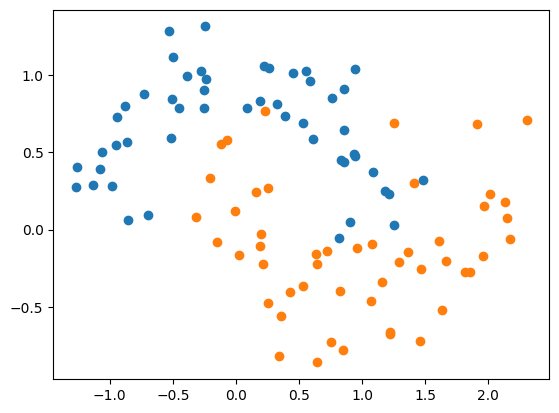

In [41]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

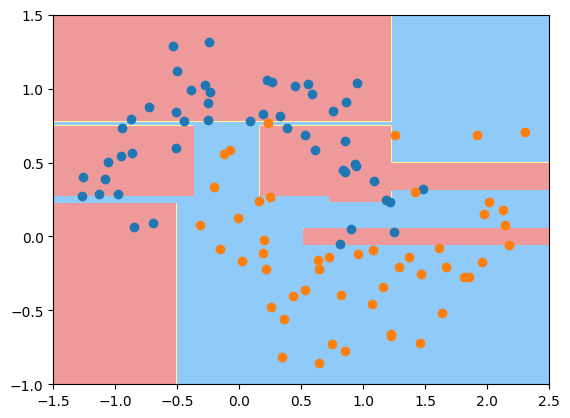

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

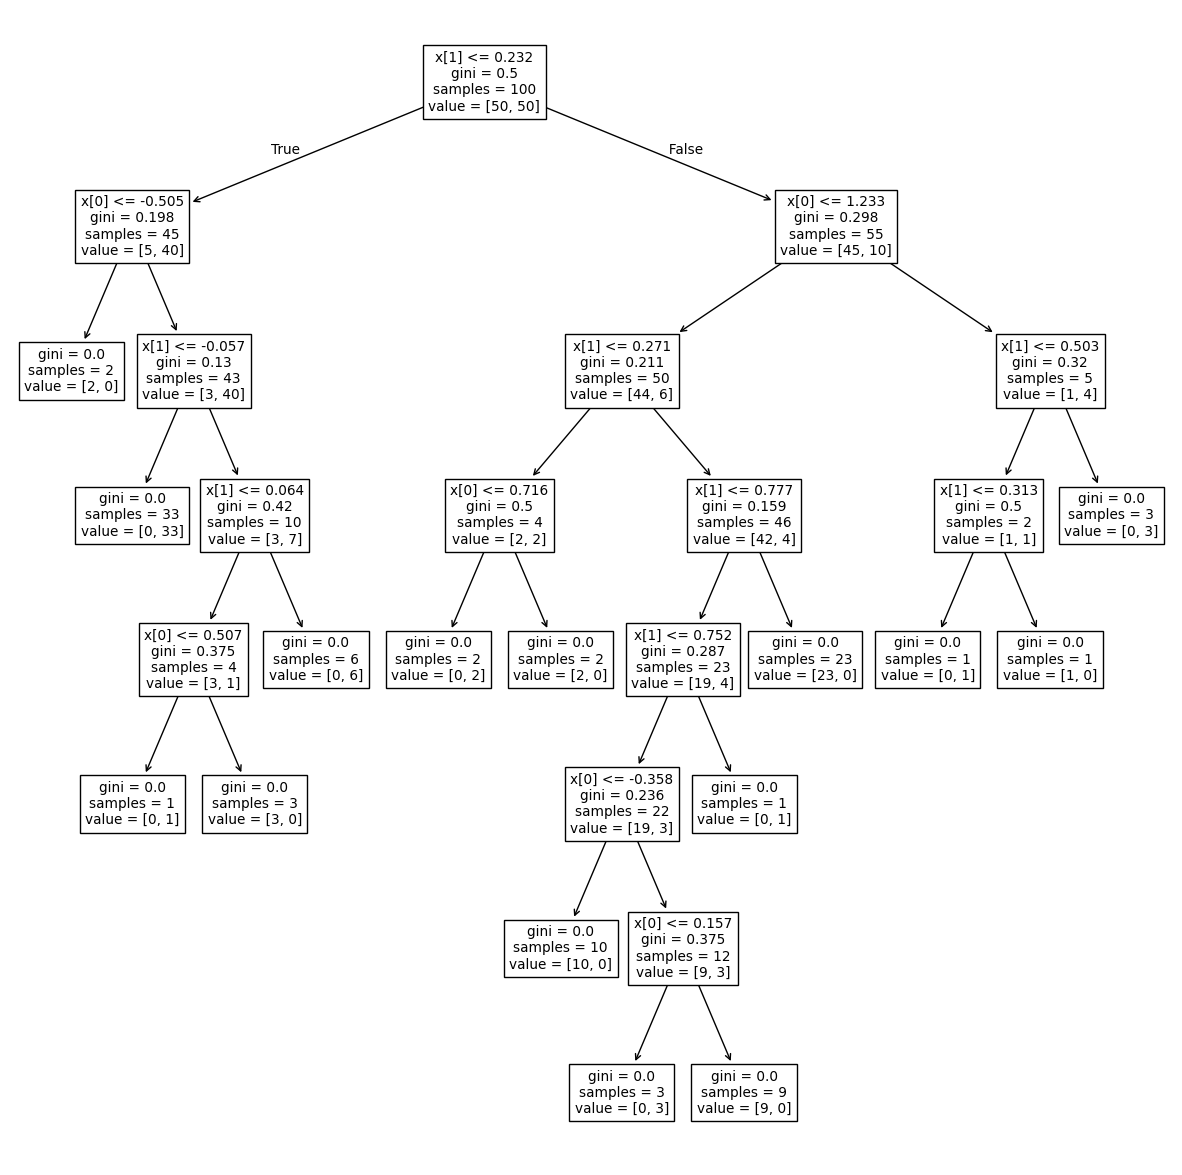

In [43]:
plt.figure(figsize=(15,15))
plot_tree(dt_clf);

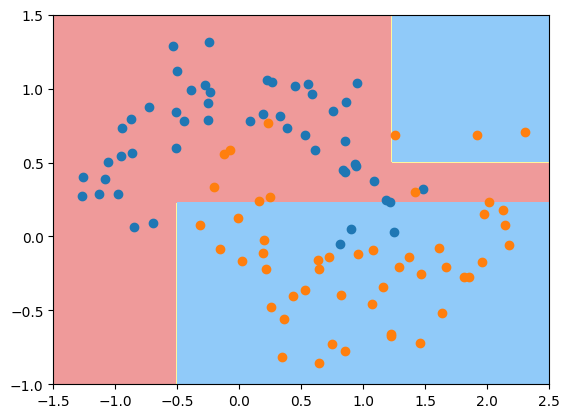

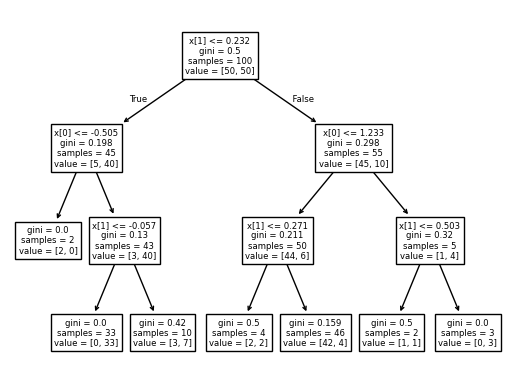

In [44]:
dt_clf2 = DecisionTreeClassifier(max_depth=3)
dt_clf2.fit(X, y)

plot_decision_boundary(dt_clf2, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()
plot_tree(dt_clf2);

In [1]:
dt_clf3 = DecisionTreeClassifier(min_samples_split=20)
dt_clf3.fit(X, y)

plot_decision_boundary(dt_clf3, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()
plot_tree(dt_clf3);

NameError: name 'DecisionTreeClassifier' is not defined

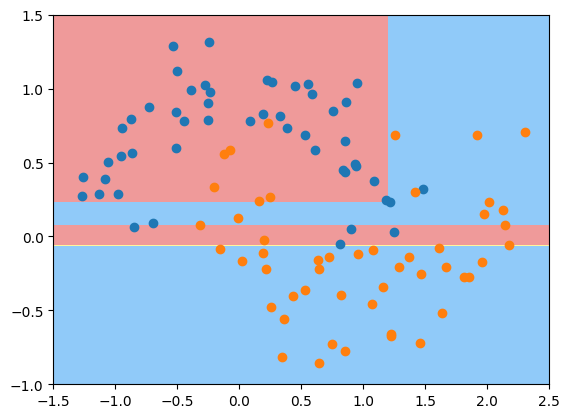

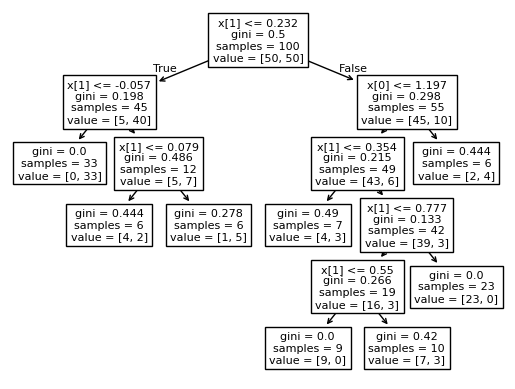

In [45]:
dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X, y)

plot_decision_boundary(dt_clf4, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()
plot_tree(dt_clf4);

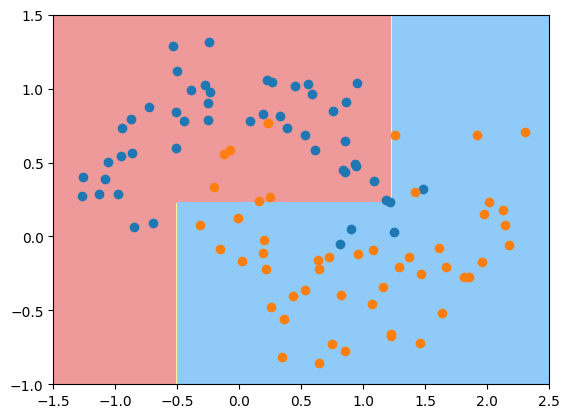

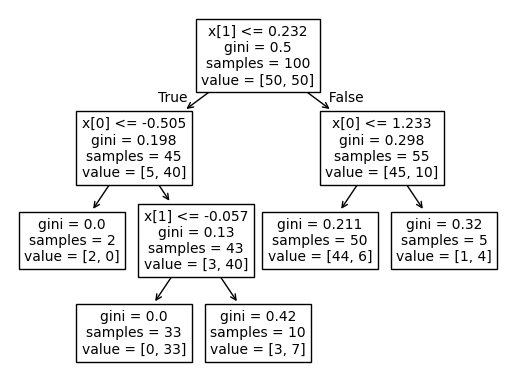

In [46]:
dt_clf5 = DecisionTreeClassifier(max_leaf_nodes=5)
dt_clf5.fit(X, y)

plot_decision_boundary(dt_clf5, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()
plot_tree(dt_clf5);

### Проблемы при использовании деревьев решений

In [47]:
iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target
X.shape

(150, 2)

In [48]:
tree_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=1)
tree_clf.fit(X, y);

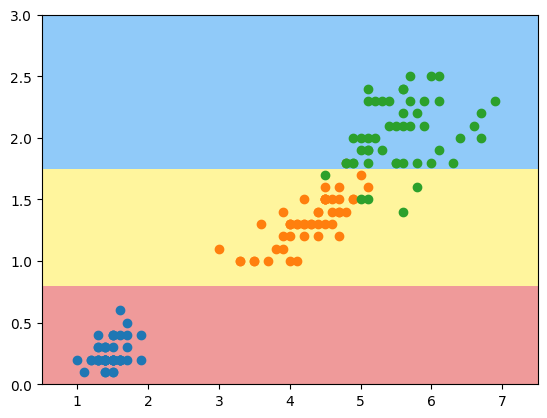

In [49]:
plot_decision_boundary(tree_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

In [50]:
X_new = np.delete(X, 140, axis=0)
y_new = np.delete(y, 140)

In [51]:
X_new.shape

(149, 2)

In [52]:
tree_clf2 = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=42)
tree_clf2.fit(X_new, y_new);

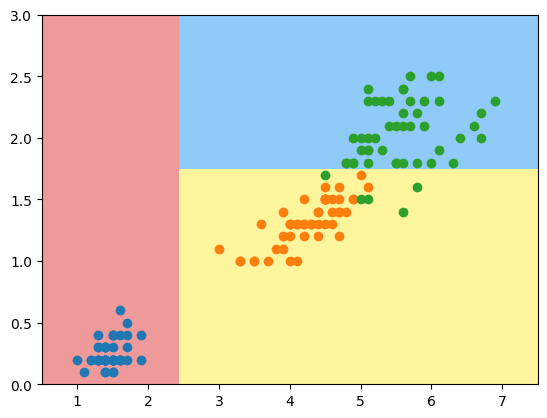

In [53]:
plot_decision_boundary(tree_clf2, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

## Ансамбли классификаторов

Ансамблевые методы (ensemble methods) создают комбинированный классификатор, используя выходные данные нескольких базовых классификаторов, которые обучаются на разных наборах данных.  
В зависимости от выбора обучающих наборов и стабильности базовых классификаторов ансамблевые классификаторы могут помочь уменьшить дисперсию и смещение, что приведет к повышению качества классификации.

In [54]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

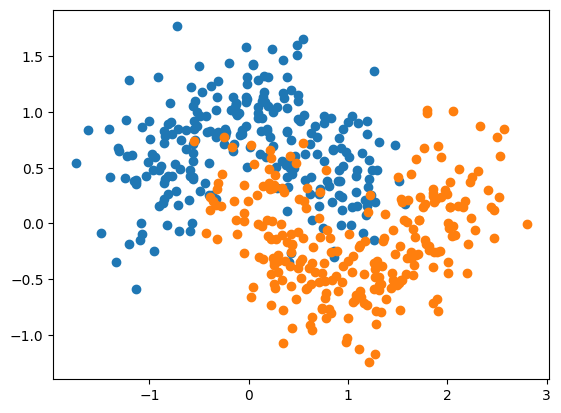

In [55]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [57]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
log_clf.score(X_test, y_test)

0.864

In [58]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.896

In [59]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=2,random_state=666)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.896

In [60]:
y_predict1 = log_clf.predict(X_test)
y_predict2 = svm_clf.predict(X_test)
y_predict3 = dt_clf.predict(X_test)

In [61]:
y_predict1

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

Построим комбинированный бинарный классификатор следующим образом:

In [62]:
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')

In [63]:
y_predict

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [64]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.904

Построенный комбинированный классификатор имеет более высокое качество классификации, чем любой из использованных базовых классификаторов.

Для построения комбинированных классификаторов в scikit-learn есть класс `VotingClassifier`, позволяющий объединить  несколько не похожих между собой классификаторов в один классификатор.

Среди параметров `VotingClassifier` есть параметр `voting` с двумя возможными значениями: 'hard' и 'soft'.
В первом случае итоговый ответ объединенного классификатора будет соответствовать «мнению» большинства входящих в него классификаторов. Во втором случае, т.е. при использовании значения 'soft' параметра  `voting` идет полноценное «голосование» и взвешивание предсказаний моделей для каждого класса, таким образом итоговый ответ объединенного классификатор — это `argmax` суммы предсказанных вероятностей.

In [65]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='hard')

In [66]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.904

При использовании класса `VotingClassifier` с параметром 'soft' получаем:

In [67]:
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='soft')

In [68]:
voting_clf2.fit(X_train, y_train)
voting_clf2.score(X_test, y_test)

0.904

Алгоритм построения стекированного классификатора реализован в классе `StackingClassifier`:

In [69]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),
    ('dt_clf', DecisionTreeClassifier(random_state=666))])

In [70]:
stacking_clf.fit(X_train, y_train)
stacking_clf.score(X_test, y_test)

0.904

## Метод бэггинга

Метод бэггинга (Bagging, Bootstrap Aggregation) представляет собой ансамблевый метод классификации, который использует несколько выборок (с заменой) из входного набора данных для создания немного различающихся обучающих наборов.
Термин `Bootstrap` означает, что используются имеющиеся данные и они размножаются при помощи выборок с заменой — в результате получаются несколько наборов одного размера и немного отличающихся друг от друга.
Бэггинг состоит из следующих шагов:
1. Получение нескольких образцов с помощью замены из вашего набора данных (бутстрэпинг).
2. Обучение классификатора для каждого образца.
3. Усреднение результатов каждого классификатора.

Основная идея бэггинга — усреднить «шумные» модели с низким смещением для создания модели с низкой дисперсией.

In [71]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

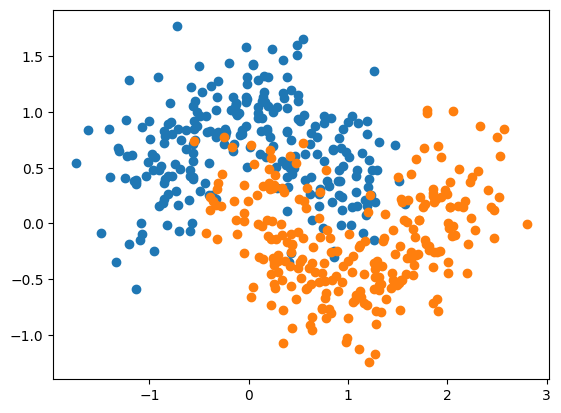

In [72]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [74]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=50, max_samples=100,
                           bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.864

In [75]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=5000, max_samples=50,
                           bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.88

## Процедура OOB (out-of-bag)

Генерация повторных случайных выборок из исходного набора данных (бутстреп) дает хорошую возможность провести специальную процедуру перекрестной проверки, называемую тестом по наблюдениям, "не попавшим в сумку" (out-of-bag observations). Поскольку ключевая идея бэггинга состоит в многократном построении моделей по наблюдениям из бутстреп-выборок, то каждое конкретное дерево строится на основе примерно двух третей всех наблюдений. Остальная треть наблюдений не используется в обучении, но вполне может быть использована для независимого тестирования.

OOB-ошибка — это встроенная версия расчёта ошибки классификатора. Это удобно, потому что  не нужно откладывать часть точек в тестовую выборку в самом начале.

In [76]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=50, max_samples=100,
                               bootstrap=True, oob_score=True)
bagging_clf.fit(X, y)
bagging_clf.score(X, y)

0.938

In [77]:
bagging_clf.oob_score_

0.92

Для ускорения обучения классификатора на многоядерных процессорах можно использовать параметр `n_jobs`:

In [78]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=50000, max_samples=100,
                               bootstrap=True, oob_score=True)
bagging_clf.fit(X, y)

CPU times: user 2min 23s, sys: 1.44 s, total: 2min 25s
Wall time: 2min 28s


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=50000, oob_score=True)

In [79]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=50000, max_samples=100,
                               bootstrap=True, oob_score=True,
                               n_jobs=-1)
bagging_clf.fit(X, y)

CPU times: user 33.1 s, sys: 1.32 s, total: 34.4 s
Wall time: 2min 32s


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=50000, n_jobs=-1, oob_score=True)

Уменьшение размера выборки может приводить к повышению качества классификатора:

In [80]:
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=500,
                               bootstrap=True, oob_score=True,
                               max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(X, y)
random_subspaces_clf.oob_score_

0.826

In [81]:
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True,
                               max_features=1, bootstrap_features=True)
random_patches_clf.fit(X, y)
random_patches_clf.oob_score_

0.852

## Случайный лес и сверхслучайные деревья

Метод случайного леса (Random Forest) представляет собой дальнейшее улучшение бэггинга деревьев решений, которое заключается в устранении корреляции между деревьями. Как и в случае с бэггингом, мы строим несколько сотен деревьев решений по обучающим бутстреп-выборкам. Однако на каждой итерации построения дерева случайным образом выбирается некоторое число признаков и разбиение разрешается выполнять только по одному из этих признаков.

In [82]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=666)

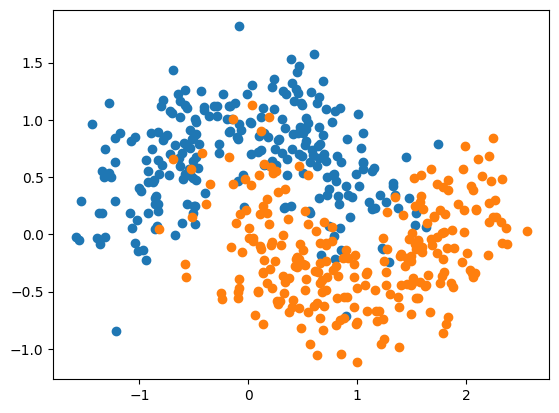

In [83]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True,
                                random_state=666, n_jobs=-1)
rf_clf.fit(X, y);

In [85]:
rf_clf.oob_score_

0.892

In [86]:
rf_clf2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, oob_score=True,
                                 random_state=666, n_jobs=-1)
rf_clf2.fit(X, y)
rf_clf2.oob_score_

0.906

### Сверхслучайные деревья (Extra-Trees)

В сверхслучайных деревьях (Extremely Randomized Trees) больше случайности в том, как вычисляются разделения в узлах. Как и в случайных лесах, используется случайное подмножество возможных признаков, но вместо поиска наиболее оптимальных порогов, пороговые значения произвольно выбираются для каждого возможного признака, и наилучший из этих случайно генерируемых порогов выбирается как лучшее правило для разделения узла. Это обычно позволяет немного уменьшить дисперсию модели за счет несколько большего увеличения смещения.

In [87]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, bootstrap=True, oob_score=True,
                              random_state=666, n_jobs=-1)
et_clf.fit(X, y);

In [88]:
et_clf.oob_score_

0.9

Сверхслучайные деревья (в качестве побочного эффекта) позволяют оценить важность признаков, чтобы в дальнейшем провести отбор на основе важности признаков.

В представленном ниже примере мы обучаем классификатор `ExtraTreesClassifier`, чтобы с его помощью определить важность признаков в наборе Ирисы.

In [89]:
# load data
iris = datasets.load_iris()
X = iris.data[:,:]
y = iris.target

In [90]:
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

[0.09671665 0.06467032 0.37852798 0.46008504]


### Случайный лес в наборе данных о кредитовании

Рассмотрим данные о кредитовании в файле __loan_data.csv__ и попытаемся классифицировать и предсказать, полностью ли заемщик выплатил свой кредит.

Данные в столбцах представляют собой следующее:

* **credit.policy**: 1, если клиент соответствует критериям кредитного андеррайтинга, и 0 в противном случае.
* **purpose**: цель ссуды (принимает значения "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business" и "all_other").
* **int.rate**: процентная ставка по ссуде в виде пропорции (ставка 11% будет сохранена как 0,11). Более рискованным заемщикам назначаются более высокие процентные ставки.
* **installment**: ежемесячные платежи, подлежащие уплате заемщиком, если ссуда финансируется.
* **log.annual.inc**: Натуральный логарифм годового дохода заемщика, представленный самооценкой.
* **dti**: отношение долга к доходу заемщика (debt-to-income, сумма долга, деленная на годовой доход).
* **fico**: кредитный рейтинг FICO заемщика.
* **days.with.cr.line**: количество дней, в течение которых у заемщика была кредитная линия.
* **revol.bal**: возобновляемый баланс заемщика (сумма, не выплаченная в конце платежного цикла кредитной карты).
* **revol.util**: коэффициент использования возобновляемой линии заемщика (сумма использованной кредитной линии по отношению к общему доступному кредиту).
* **inq.last.6mths**: количество запросов от кредиторов заемщиком за последние 6 месяцев.
* **delinq.2yrs**: количество случаев просрочки платежа заемщиком на 30+ дней за последние 2 года.
* **pub.rec**: количество негативных публичных записей заемщика (заявления о банкротстве, налоговые залоги или судебные решения).
* **not.fully.paid**: количество процентов для классификации - выплатил ли заемщик деньги полностью или нет.

In [91]:
df = pd.read_csv('loan_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'loan_data.csv'

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
print("Данные об одобрении кредитов. 1 означает одобренный кредит, 0 - не одобренный.")
print(df['credit.policy'].value_counts())

In [ ]:
df[df['credit.policy']==1]['fico'].plot.hist(bins=30,alpha=0.5,color='blue', label='Credit.Policy=1')
df[df['credit.policy']==0]['fico'].plot.hist(bins=30,alpha=0.5, color='red', label='Credit.Policy=0')
plt.legend(fontsize=15)
plt.title ("Гистограмма скорингового балла FICO \nпо одобренным и не одобренным кредитам", fontsize=15)
plt.xlabel("FICO score", fontsize=14);

Признак **purpose** является категориальным. Преобразуем его в числовые признаки:

In [ ]:
df_final = pd.get_dummies(df,['purpose'],drop_first=True)
df_final.head()

In [ ]:
X = df_final.drop('not.fully.paid',axis=1)
y = df_final['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=None)
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

In [ ]:
plt.figure(figsize=(15,15))
plot_tree(dtree); # max_depth

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

In [ ]:
cm=confusion_matrix(y_test,predictions)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))

Тренируем случайный лес и выполняем предсказание:

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [ ]:
cr = classification_report(y_test,rfc_pred)
print(cr)

In [ ]:
cm = confusion_matrix(y_test,rfc_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))

In [ ]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,
                                 min_samples_split=10,max_depth=None,criterion='gini')
    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    cm = confusion_matrix(y_test,rfc_pred)
    accuracy[i] = (cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
plt.title("Число деревьев в случайном лесу и точность прогноза (критерий: 'gini')",
          fontsize=15)
plt.xlabel("Number of trees", fontsize=14)
plt.ylabel("Точность прогноза по матрице ошибок", fontsize=14);

## Бустинг

Бустинг (boosting) - это ансамблевый метод, объединяющий нескольких слабых классификаторов, чтобы сформировать сильный классификатор. Под слабым классификатором понимается модель, которая работает немногим лучше случайного выбора. Самыми популярными методами бустинга являются:
* AdaBoost
* градиентный бустинг

Основная идея метода бустинга состоит в том, чтобы тщательно отбирать точки, чтобы повысить качество классификации для трудно классифицируемых точек.

In [ ]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=666)

In [ ]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

### AdaBoost

* Адаптивный бустинг (__Ada__ptive __Boost__ing)
* Каждый следующий классификатор уделяет больше внимания случаям, ошибочно предсказанным его предшественниками.
* Достигается за счет изменения весов в обучающихся классификаторах.
* Каждому классификатору присваивается коэффициент, который зависит от ошибки обучения классификатора.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=500)
ada_clf.fit(X_train, y_train)
ada_clf.score(X_test, y_test)

В рассматриваемом примере можно спрогнозировать вероятности получения положительного класса в тестовой выборке при помощи метода `predict_proba()`, извлекая эти вероятности из второго  столбца следующим образом:

In [ ]:
y_pred_proba = ada_clf.predict_proba(X_test)[:,1]
y_pred_proba

Теперь можно оценить классификатор `ada_clf` при помощи показателя `ROC_AUC`. Напомним, что показатель `ROC_AUC` для бинарного классификатора можно определить с помощью функции `roc_auc_score()` из `sklearn.metrics`.

In [ ]:
from sklearn.metrics import roc_curve

fprs, tprs, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fprs, tprs)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

### Метод градиентного бустинга

* Последовательное исправление ошибок предшествующего классификатора.
* Веса точек обучающей выборки не изменяются.
* Каждый классификатор обучается с использованием остаточных ошибок своего предшественника в качестве меток.
* Деревья с градиентным бустингом: CART используется в качестве базового алгоритма.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=30)
gb_clf.fit(X_train, y_train)
gb_clf.score(X_test, y_test)

In [ ]:
y_pred_proba = gb_clf.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fprs, tprs)
plt.show()

In [ ]:
# Evaluate test-set roc_auc_score
gb_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(gb_roc_auc))

### Задание на лабораторную работу №6

#### Задание (10 баллов)

Для закрепленного за Вами варианта лабораторной работы:

1. Считайте заданный набор данных из репозитария UCI, включая указанный в индивидуальном задании столбец с метками классов.

2. Если среди меток класса имеются пропущенные значения, то удалите записи с пропущенными метками класса. Преобразуйте категориальные признаки в числовые при помощи кодирования меток (label encoding). Если в признаках имеются пропущенные значения, то замените пропущенные значения, используя метод, указанный в индивидуальном задании. Если в признаках пропущенных значений нет, то удалите из набора данных записи, идентифицированные как выбросы при помощи метода кластеризации DBSCAN.

3. Используя метод снижения размерности данных, указанный в индивидуальном задании, определите и оставьте в наборе данных не более четырех признаков.

4. Нормализуйте оставшиеся признаки набора данных методом, указанным в индивидуальном задании.

5. Визуализируйте набор данных в виде точек в трехмерном пространстве, отображая точки разных классов разными цветами. При визуализации набора данных используйте три признака с наиболее высокой оценкой важности. В качестве подписей осей используйте названия признаков. В подписи рисунка укажите название набора данных. Создайте легенду набора данных.

6. Разбейте набор данных на обучающую и тестовую выборки. Создайте и обучите классификатор на основе деревьев решений с глубиной дерева не более 4, определите долю верных ответов на тестовой выборке и визуализируйте границу принятия решений и построенное дерево решений. При визуализации границы принятия решений используйте два признака с наиболее высокой оценкой важности.

7. Постройте и обучите дополнительные базовые классификаторы, указанные в индивидуальном задании, затем постройте из классификатора дерева решений и дополнительных классификаторов комбинированный классификатор, указанный в индивидуальном задании. Оцените производительность базовых классификаторов и комбинированного классификатора по показателю, указанному в индивидуальном задании.

8. Постройте и обучите пару ансамблевых классификаторов, указанных в индивидуальном задании, и сравните их производительность по показателю, указанному в индивидуальном задании.

9. Постройте границы принятия решений ансамблевых классификаторов с визуализацией точек набора данных разных классов разными цветами. Подпишите оси и рисунок.

